# 추노 Excon E10 이미지 세그멘테이션

## shallow focus 만드는 방법
![image](study/study_1.png)

## 전체 프로젝트 process
1. DeepLab 모델 준비
2. 사전 학습 가중치 불러오기
3. 마스크 만들기
4. 세그멘테이션 결과 원복
5. 인물 사진 잘라내기
6. 배경 흐릿하게 만들기
7. 흐릿하게 바뀐 배경과 잘라낸 인물 사진 합치기

***

In [1]:
# 필요한 라이브러리 불러오기
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

# 사진 불러오기
import os
img_path = os.getenv('HOME')+'/1.AIFFEL_Study/Exploration/E10_Image_Semantic_Segmentation/pics/image2.jpg'
img_orig = cv2.imread(img_path) # 인물 사진

***

# 1. DeepLab 모델 준비

In [45]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

## 코드 파헤치기

In [ ]:
def __init__(self, tarball_path):
    self.graph = tf.Graph()
    """
    Graph는 노드(node)나 꼭지점(vertex)로 연결 되어 있는 개체(entity)의 집합을 부르는 용어
    (출처: https://excelsior-cjh.tistory.com/151)
    
    Graph 이점
    유연성이 크게 향상, 모바일 애플리케이션, 임베디드 기기 및 백엔드 서버와 같은 Python 인터프리터가 없는 환경에서 TensorFlow 그래프를 사용가능
    TensorFlow가 빠르게, 병렬로, 그리고 효율적으로 여러 기기에서 실행할 때 아주 유용
    (출처: https://www.tensorflow.org/guide/intro_to_graphs?hl=ko)
    """
    graph_def = None
    tar_file = tarfile.open(tarball_path)  # 가중치 경로를 통해 파일 오픈
    for tar_info in tar_file.getmembers(): # 가중치 파일들을 불러서 반복문 적용
        """
        Type.GetMembers 메서드: 현재 Type의 모든 public 멤버를 반환합니다.
        출처: https://docs.microsoft.com/ko-kr/dotnet/api/system.type.getmembers?view=net-5.0
        """
        if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name): # __init__에서 선언한 'frozen_inference_graph'과 같은 이름이면
            file_handle = tar_file.extractfile(tar_info) # 아카이브에서 멤버(member)를 파일 객체로 추출(https://docs.python.org/ko/3/library/tarfile.html)
            graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read()) # 추출한 파일 객체를 읽어 가중치를 사용
            """
            .read()은 아래 마크다운에서 예시로 설명
            tf.compat.v1.GraphDef.FromString은 가중치를 얼려서 다시 사용하려고 부를때 사용(출처: https://wikidocs.net/51521)
            """
            break
    tar_file.close()

    with self.graph.as_default():
        tf.compat.v1.import_graph_def(graph_def, name='') # 그래프 기본값 정의

    self.sess = tf.compat.v1.Session(graph=self.graph) # 세션 정의

### .read()
![read()](study/study_2.png)
**파일 내부의 객체를 읽어오는 기능**
> 출처: https://wilkelab.org/classes/SDS348/2020_spring/worksheets/class18.html

In [ ]:
# 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
def preprocess(self, img_orig): # img_orig는 인물 사진 입력
    height, width = img_orig.shape[:2] # 높이, 너비 정의, height = img_orig.shape[0], width = img_orig.shape[1]
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height) # resize 비율 설정
    target_size = (int(resize_ratio * width), int(resize_ratio * height)) # 타겟 사이즈 설정 = (비율*너비, 비율*높이)
    resized_image = cv2.resize(img_orig, target_size) # cv2.resize를 이용해 타겟 사이즈로 사이즈 변경
    resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB) # BGR -> RGB컬러로 변경
    img_input = resized_rgb # img_input 변수에 담기
    return img_input

def run(self, image):
    img_input = self.preprocess(image) # 위에서 정의한 preprocess함수를 사용해 입력 이미지에 대해 할당

    # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
    """
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    batch_seg_map변수에 sess.run을 실행: 연산 그래프를 실행하는 메소드
        인자로는 OUTPUT_TENSOR_NAME과 {INPUT_TENSOR_NAME : (전처리된)입력 이미지}
    """
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

    seg_map = batch_seg_map[0] # 0번째 인자를 seg_map에 할당
    """
    seg_map의 길이는 resize된 이미지의 height와 같다. 즉 이미지 전체를 라벨링한 값들이 들어있다. 0이라면 배경 15라면 사람이다.
    """
    return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [47]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

print(img_resized.shape)
print(len(seg_map))
print(seg_map[350])

(384, 513, 3)
384
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15

***

# 2. 사전 학습된 가중치 불러오기
- deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight

In [3]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)
# 여기까지는 가중치 다운로드

# MODEL변수에 DeepLabModel클래스에 가중치를 입력해 할당.
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

img_resized, seg_map = MODEL.run(img_orig) # 첫 단계에서 준비한 이미지를 네트워크에 입력
"""
resize된 이미지와 라벨링 값들을 할당.
DeepLabModel클래스의 run 함수 작동
"""

temp directory: /home/aiffel-dj40/aiffel/human_segmentation/models
model loaded successfully!


In [4]:
print (img_orig.shape, img_resized.shape, seg_map.max()) # seg_map.max() == 15는 사람

(750, 1000, 3) (384, 513, 3) 15


***

# 3. 마스크 만들기

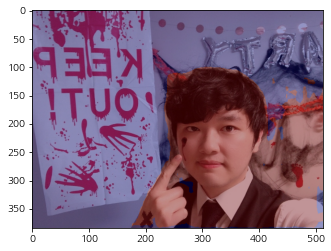

In [5]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization(정규화)
img_mask = img_mask.astype(np.uint8)# 아래 마크다운에서 설명
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
"""
cv2.applyColorMap: 색을 적용 Apply the colormap: applyColorMap(img_in, img_color, COLORMAP_JET)
COLORMAP_JET: 컬러맵 타입 중 하나 (아래 마크다운에서 설명)
"""
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
"""
cv2.addWeighted: 가중치를 부여해 적용
결과 = img_show * 0.6 + color_mask * 0.35 + 0.0
예시는 아래 마크다운에서 설명
"""

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### astype(np.uint8)
#### 1) astype: type 변경
#### 2) unit8: 양수만 표현 가능, 2^8개 표현 가능, 0~255
![unit8](study/study_3.png)
> **출처: https://kongdols-room.tistory.com/53**  

### COLORMAP_JET
![COLORMAP_JET](study/study_4.png)
> **출처: [여기](https://docs.opencv.org/master/d3/d50/group__imgproc__colormap.html#gga9a805d8262bcbe273f16be9ea2055a65ab3f207661ddf74511b002b1acda5ec09)**  

### addWeighted
![addWeighted](study/study_5.png)
> **출처: http://www.gisdeveloper.co.kr/?p=6407**  



***

# 4. 세그멘테이션 결과 원복

In [49]:
print(img_orig.shape[:2])
print(img_orig.shape[:2][::-1])

(750, 1000)
(1000, 750)


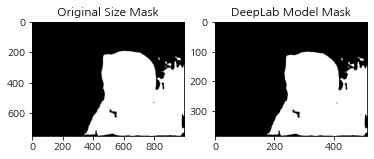

In [6]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
"""
img_orig.shape[:2][::-1]: img_orig.shape을 뒤에서부터 정렬
interpolation: 보간법, 이미지의 크기를 변경하는 경우, 변형된 이미지의 픽셀은 추정해서 값을 할당.
    이미지의 비율을 변경하면 존재하지 않는 영역에 새로운 픽셀값을 매핑하거나 존재하는 픽셀들을 압축해서 새로운 값을 할당해야 함
    (출처: https://076923.github.io/posts/Python-opencv-8/)
    
cv2.resize: (입력 이미지, 절대 크기, 보간법)
"""

_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

"""
아래 마크다운에서 설명
"""

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### cv2.resize
![resize](study/study_6.png)
> **출처: https://m.blog.naver.com/samsjang/220504782549**

***

# 5. 인물 사진 잘라내기

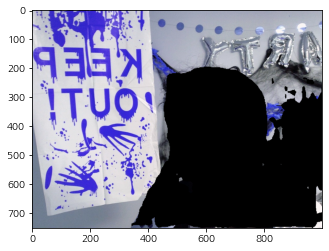

In [7]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) # bitwise_not은 이미지 반전 (흰색은 검정, 검정은 흰색)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask) # 원본 이미지와 반전된 이미지 둘 다 만족하는 공간 = 사람이 아닌 배경

plt.imshow(img_bg)
plt.show()

### bitwise_and
![bitwise_and](study/study_7.png)
> **출처: https://copycoding.tistory.com/156**

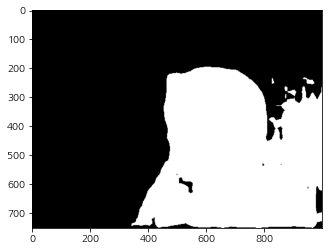

In [51]:
plt.imshow(img_mask_color)
plt.show()

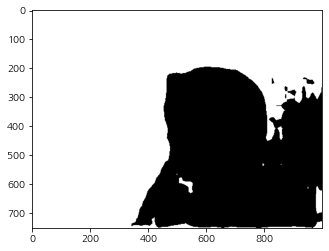

In [52]:
plt.imshow(img_bg_mask)
plt.show()

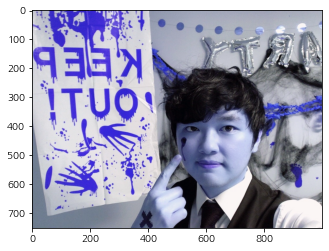

In [53]:
plt.imshow(img_orig)
plt.show()

***

# 6. 배경 흐릿하게 만들기

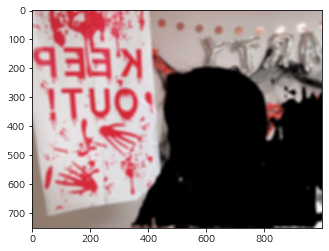

In [8]:
img_bg_blur = cv2.blur(img_bg, (13,13)) 
"""
cv2.blur: (이미지, 13*13 범위 내 이웃 픽셀의 평균을 결과 이미지의 픽셀값으로하는 평균 블러링)
"""
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 5\*5 적용
- 13\*13보다 더 선명하다!

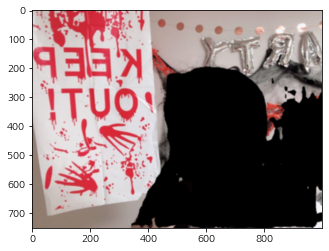

In [54]:
img_bg_blur_ = cv2.blur(img_bg, (5,5)) 
plt.imshow(cv2.cvtColor(img_bg_blur_, cv2.COLOR_BGR2RGB))
plt.show()

### 26\*26 적용
- 13\*13보다 더 흐릿하다! **(하지만 너무 흐릿)**

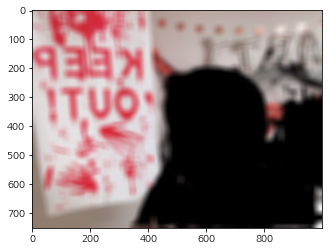

In [55]:
img_bg_blur_ = cv2.blur(img_bg, (26,26)) 
plt.imshow(cv2.cvtColor(img_bg_blur_, cv2.COLOR_BGR2RGB))
plt.show()

***

# 7. 흐릿하게 바뀐 배경과 잘라낸 인물 사진 합치기

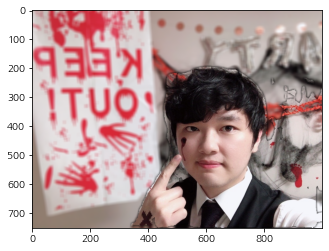

In [9]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
"""
numpy.where를 활용
img_mask_color==255(흰색)이라면 img_orig(원본, 인물 사진)을 적용하고
아니라면 img_bg_blur(흐릿하게 처리한 배경)을 적용
>> img_mask_color은 인물 부분이 흰색이다! 아래 참고
"""
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

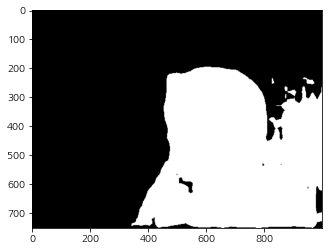

In [56]:
plt.imshow(img_mask_color)
plt.show()

***

# 추가!
### 배경 바꾸기 꿀팁 (numpy.where() 응용)
- 시간이 남으면 간단하게 짚고 넘어가기

In [67]:
# 배경 사진 불러오기
import os
img_path = os.getenv('HOME')+'/1.AIFFEL_Study/Exploration/E10_Image_Semantic_Segmentation/pics/eiffel.jpg'
img_new_bg = cv2.imread(img_path) 
print (img_new_bg.shape) # (세로, 가로, 채널수)

(1279, 1920, 3)


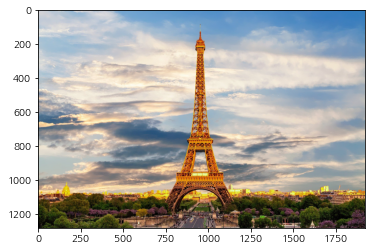

In [68]:
# 배경 사진 확인
img_rgb = cv2.cvtColor(img_new_bg, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### 인물 사진이 들어갈 위치 조정
- 우측 하단에 위치하도록 좌표값 설정

In [69]:
# 인물 사진 위치 중 좌측 상단 = (1279-1000, 1920-750)
# 인물 사진 위치 중 우측 하단 = (1279, 1920) # 세로, 가로

person_left_top_x = img_new_bg.shape[1] - img_orig.shape[1]
person_left_top_y = img_new_bg.shape[0] - img_orig.shape[0]
person_right_down_x = img_new_bg.shape[1]
person_right_down_y = img_new_bg.shape[0]

print('배경 사진 중 인물 사진이 들어갈 위치 중 좌측 상단 좌표값은 ({},{})이며 우측 하단 좌표값은 ({},{})이다.'\
      .format(person_left_top_x,person_left_top_y,person_right_down_x,person_right_down_y))

배경 사진 중 인물 사진이 들어갈 위치 중 좌측 상단 좌표값은 (1170,279)이며 우측 하단 좌표값은 (1920,1279)이다.


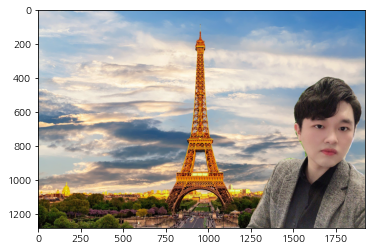

In [70]:
person_area = img_new_bg[person_left_top_y:person_right_down_y, person_left_top_x:person_right_down_x]

img_new_bg[person_left_top_y : person_right_down_y, person_left_top_x : person_right_down_x] = \
np.where(img_mask_color_==255, img_orig, person_area)
plt.imshow(cv2.cvtColor(img_new_bg, cv2.COLOR_BGR2RGB))
plt.show()